In [636]:
import pandas as pd
from matplotlib import pyplot as plt
import re
import numpy as np

In [ ]:
#!pip install inflecteur

In [ ]:
from inflecteur import inflecteur

inflecteur = inflecteur()
inflecteur.load_dict()

## Chargement des données

In [5]:
firstname = pd.read_csv('firstname_with_sex.csv', sep=';')
df = pd.read_csv('transcriptions_with_sex.csv')

## Statistiques descriptives

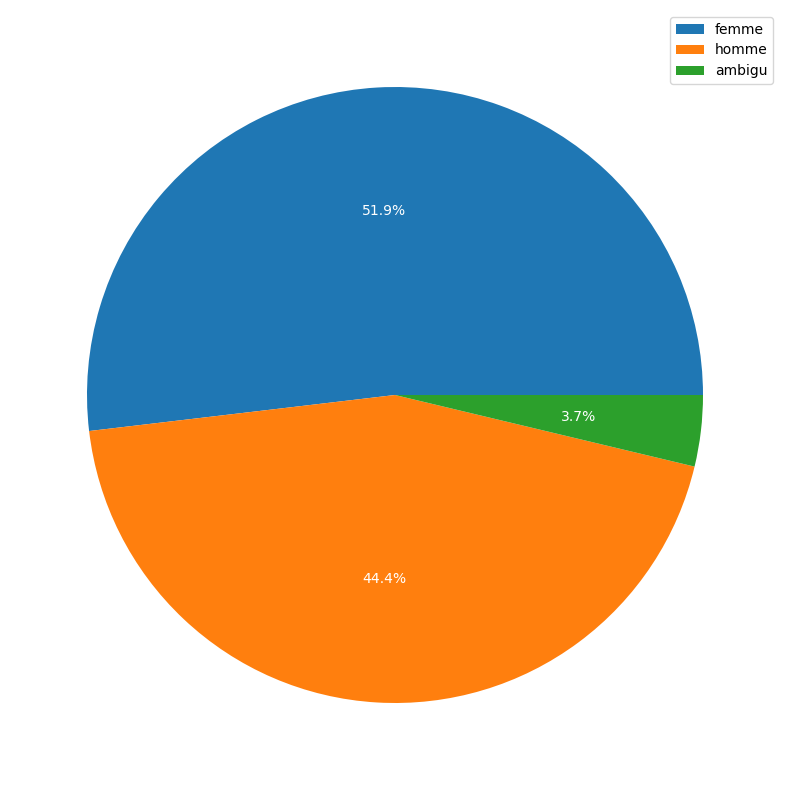

In [106]:
#Sexe
plt.figure(figsize=(10,10))
plt.pie(df.sex.value_counts(), labels=df.sex.unique(),autopct=lambda x: f"{x:.1f}%",textprops=dict(color="w"))
plt.legend()
plt.show()

<BarContainer object of 9 artists>

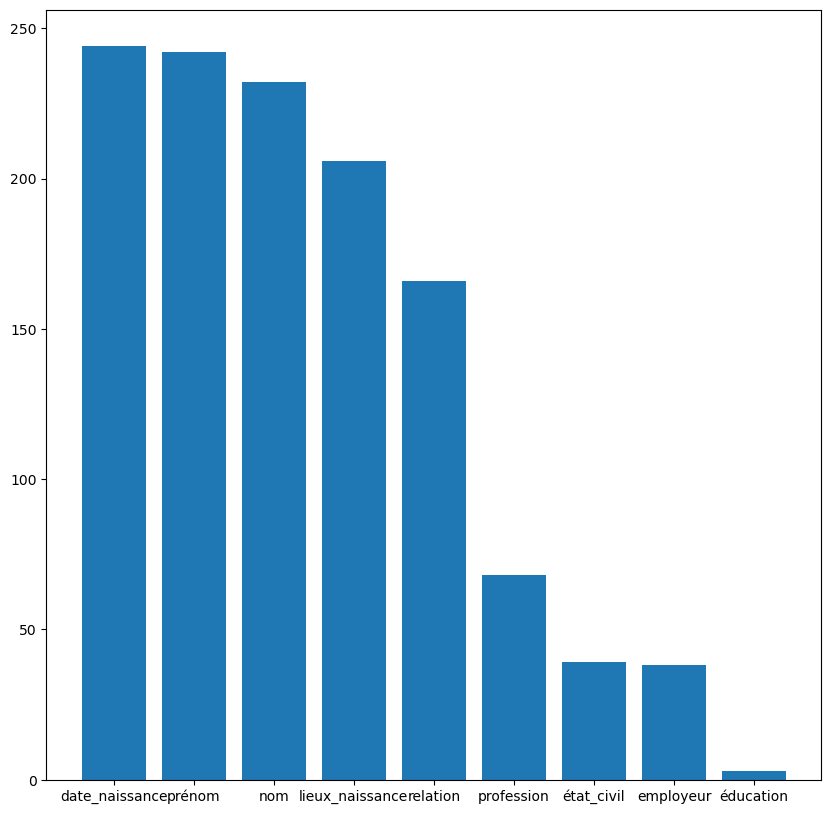

In [117]:
#Prédiction
str_expand = df.prediction.str.split(expand=True).stack()
str_expand = str_expand[str_expand.apply(lambda x : ':' in x)].value_counts()
plt.figure(figsize=(10,10))
plt.bar(str_expand.index.str.replace(':',''),str_expand.values,)

<BarContainer object of 10 artists>

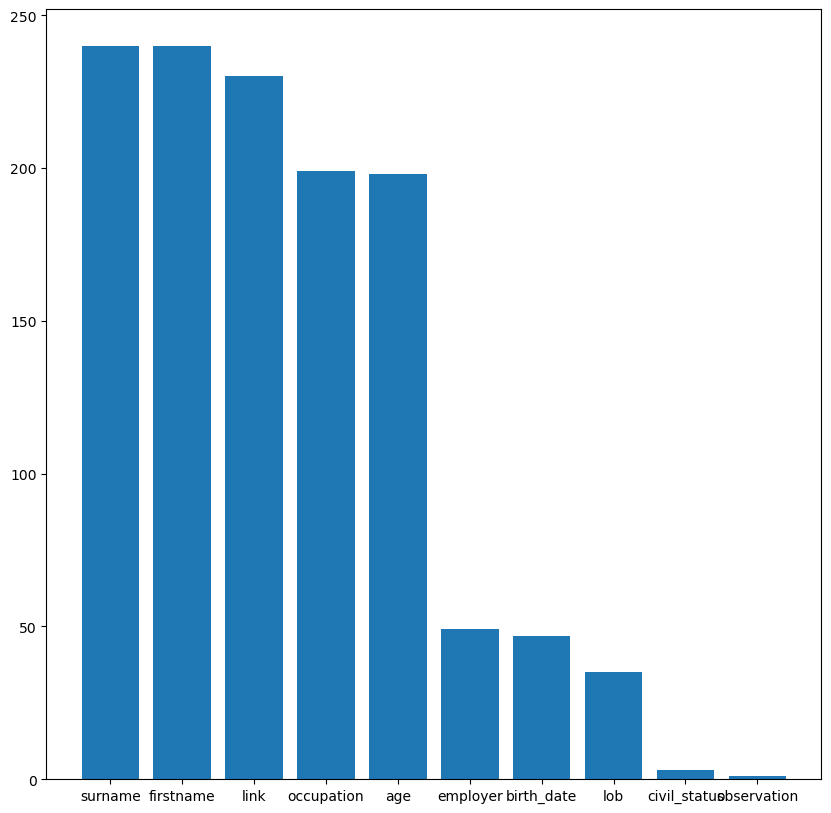

In [118]:
#Groundtruth
str_expand = df.groundtruth.str.split(expand=True).stack()
str_expand = str_expand[str_expand.apply(lambda x : ':' in x)].value_counts()
plt.figure(figsize=(10,10))
plt.bar(str_expand.index.str.replace(':',''),str_expand.values,)

## Extraction des features pour le modèle

In [595]:
firstname_features = firstname.copy()
firstname_features['ratio'] = firstname_features.female/(firstname.male+firstname.female)

In [596]:
df_features = df.copy()
for feat in ['firstname','occupation','link'] :
    regex = feat+':\s*([^:\s]+(?:\s+[^:\s]+)*?)\s*\w+:'
    df_features[feat] = df_features.groundtruth.str.extract(regex)[0]
df_features = df_features[['firstname','occupation','link','sex']]

In [597]:
def imputation_idem(liste) :
    """
    Entrée :
            liste, type list, la liste des valeurs de la colonne
    Sortie :
            liste, type list, la liste des valeurs modifiée où lorsqu'une entrée "idem" apparaît, on la remplace par l'entrée précédente
    """
    for i, item in enumerate(liste) :
        if item == 'idem' :
            liste[i] = liste[i-1]
    return liste

In [598]:
# Imputation des "idem"
df_features['link'] = df_features['link'].fillna('néant')
df_features['link'] = df_features['link'].replace('idem',pd.NA)
df_features['link'] = df_features['link'].ffill()

df_features['occupation'] = df_features['occupation'].fillna('néant')
df_features['occupation'] = df_features['occupation'].replace('idem',pd.NA)
df_features['occupation'] = df_features['occupation'].ffill()
df_features.loc[0,'occupation'] = 'sp'

In [599]:
# Standardisation des sans profession
dict_sp = {'s.p':'sp', 'sans prof':'sp', 's.p.':'sp', 'sans prof.':'sp', 'sans p.':'sp', 'Sans p':'sp', 'sans p':'sp', 's p':'sp'}
df_features = df_features.replace({'occupation':dict_sp})

In [600]:
def gender_score(s) :
    """
    Entrée :
            s, une chaîne de caractère, le champ à analyser
    Sortie: 
            score, le score entre 0 et 1 qui traduit comment les mots qui composent la chaîne se réfère à des noms féminins ou masculins
    """
    if ' de ' in s :
        l_mots = re.findall(r'\w+\s+(?=de\b)', s)
    else :
        l_mots = s.split()

    score = 1/2
    modified = False

    if s == 'sp' or s == 'néant' :
        return(score)
    
    for w in l_mots :
        df_sens = inflecteur.get_word_form(w.lower())
        if df_sens is None :
            continue
        elif len(df_sens[df_sens.gram == 'Nom']) == 0 :
            continue
        else :
            gender = df_sens[df_sens.gram == 'Nom'].gender.map({'M' : 0, 'F' : 1})
            if modified :
                score += gender.mean()
            else :
                modified = True
                score = 0
                score += gender.mean()

    score = score/len(l_mots)
    return score

In [601]:
# Calcul du score de genre des champs "link" et "occupation"
df_features['score_occupation'] = df_features.occupation.apply(gender_score)
df_features['score_link'] = df_features.link.apply(gender_score)
df_features['sex'] = df_features['sex'].map({'femme' : 1, 'homme' : 0})

In [602]:
def clean_name(s) :
    """
        Entrée :
                s, type str, le prénom considéré
        Sortie :
                s_clean, type str, le premier prénom en lettres minuscules
    """
    s_clean = s.replace('-',' ')
    s_clean = s_clean.split()[0]
    return(s_clean.lower())

In [603]:
# Ajout de la colonne du ratio de femmes portant le prénom
df_features = df_features[~df_features.firstname.isna()]
df_features.loc[:,'firstname'] = df_features['firstname'].map(clean_name)

name_matching = {k : v for k, v in zip(firstname_features.firstname.values,firstname_features.ratio.values)}
df_features['score_firstname'] = df_features.firstname.map(name_matching)

In [609]:
df_features[['sex','score_occupation','score_link','score_firstname']].cov()

,sex,score_occupation,score_link,score_firstname
sex,0.249727,0.049113,0.108212,0.245277
score_occupation,0.049113,0.062415,0.014841,0.049687
score_link,0.108212,0.014841,0.114325,0.101652
score_firstname,0.245277,0.049687,0.101652,0.244802


In [623]:
df_features = df_features[['sex','score_occupation','score_link','score_firstname']]
df_features = df_features[(~df_features.sex.isna()) & (~df_features.score_firstname.isna())]

## Modèle

In [655]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

In [626]:
X = df_features.drop(columns=["sex"])
y = df_features["sex"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

In [627]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_model = RandomForestClassifier()

# Initialiser GridSearchCV avec le modèle, les hyperparamètres et la validation croisée
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=4, scoring='accuracy', verbose=2, n_jobs=-1)

# Effectuer la recherche sur grille sur les données d'entraînement
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 108 candidates, totalling 432 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=2)

In [658]:
print("Meilleurs paramètres trouvés par GridSearchCV:")
print(grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Exactitude (Accuracy) sur les données de test:", accuracy)
roc_auc = roc_auc_score(y_test, y_pred_proba[:,1])
print("ROC AUC sur les données de test:", roc_auc)

Meilleurs paramètres trouvés par GridSearchCV:
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Exactitude (Accuracy) sur les données de test: 0.9782608695652174
ROC AUC sur les données de test: 0.9940476190476191


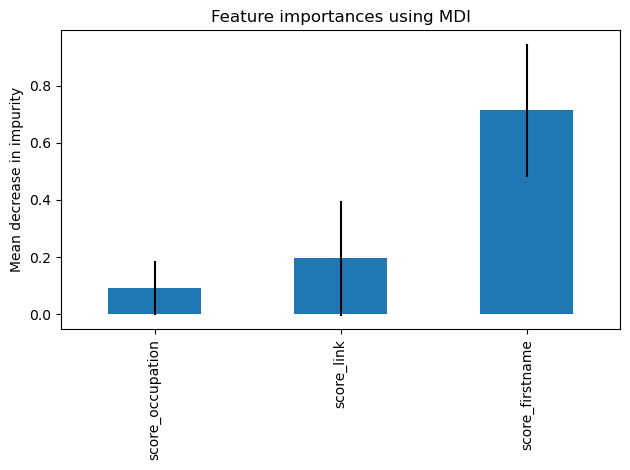

In [664]:
#Importance relative de chaque feature
importances = best_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in best_model.estimators_], axis=0)

forest_importances = pd.Series(importances, index=X.columns.values)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [667]:
X_test[np.abs(y_test - best_model.predict(X_test)) == 1]

,score_occupation,score_link,score_firstname
146,1.0,0.5,0.995774


In [668]:
df.iloc[146,:].groundtruth

'surname: Tessin firstname: Marie occupation: cultivatrice link: domestique employer: Lavocat birth_date: 1891 lob: Coulanges '